<a href="https://colab.research.google.com/github/beatricekiplagat/Deepfake-Audio-Recognition/blob/dev_branch/DEEPFAKE_AUDIO_DETECTION_TRANSFER_LEARNING_MODELS_WITH_WANDB_INTERGRATION_InceptionV3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install wandb

In [ ]:
# import necessary libraries
import wandb
from wandb.keras import WandbCallback
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from tqdm import tqdm
import math
import os

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.callbacks import *
from tensorflow.keras import backend as K
K.clear_session()
import itertools

import cv2
import matplotlib.cm as cm

from tensorflow.keras.utils import to_categorical


import tensorflow as tf

In [ ]:
# Initialize wandb
wandb.login()
wandb.init(project='DeepFake Audio Detection', entity='ruoro',
           config = {
               'learning_rate': 0.002,
               'epochs': 5,
               'batch_size': 4,
               'loss_function':"binary_crossentropy"
           }
)

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: ruoro (use `wandb login --relogin` to force relogin)


In [ ]:
#Mount google drive to access data

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

# define train and test data
from PIL import Image
import glob
train_path = []
for filename in glob.glob('/content/drive/MyDrive/DEEPFAKE AUDIO DETECTION PROJECT/DATASETS/Train/Spoof/*.png'):
    im=Image.open(filename)
    train_path.append(im)
for filename in glob.glob('/content/drive/MyDrive/DEEPFAKE AUDIO DETECTION PROJECT/DATASETS/Train/Bonafide/*.png'):
    im=Image.open(filename)
    train_path.append(im)
from PIL import Image
import glob
valid_path = []
for filename in glob.glob('/content/drive/MyDrive/DEEPFAKE AUDIO DETECTION PROJECT/DATASETS/Test/Bonafide/*.png'):
    im=Image.open(filename)
    valid_path.append(im)
for filename in glob.glob('/content/drive/MyDrive/DEEPFAKE AUDIO DETECTION PROJECT/DATASETS/Test/Spoof/*.png'):
    im=Image.open(filename)
    valid_path.append(im)

In [ ]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

In [ ]:
# add preprocessing layer to the front of Inception
# the include_top false statement will allow us to be able to set the number of classes on the top layer that we will create
incept = InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# don't train - incept has existing weights
for layer in incept.layers:
  layer.trainable = False
  


87916544/87910968 [==============================] - 1s 0us/step


In [ ]:
  # useful for getting number of classes
  # this will count the number of classes we have in our dataset assuming that the data is grouped into specific folders
from glob import glob
folders = 1 #glob('/content/drive/MyDrive/DEEPFAKE AUDIO DETECTION PROJECT/DATASETS/Test/*')

In [ ]:
import numpy as np
from tqdm import tqdm
import math
import os

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.callbacks import *
from tensorflow.keras import backend as K
K.clear_session()
import itertools
import matplotlib.pyplot as plt
import cv2
import matplotlib.cm as cm

from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer,LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import tensorflow as tf

In [ ]:
# our layers
x = Flatten()(incept.output)
# x = Dense(1000, activation='relu')(x)
prediction = Dense(folders, activation='sigmoid')(x)

# #adding the output layer
# cnn.add(tf.keras.layers.Dense(units = 1 , activation = 'sigmoid'))


In [ ]:

# create a model object
model = Model(inputs=incept.input, outputs=prediction)
# view the structure of the model
model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
# tell the model what cost and optimization method to use
model.compile(
  loss='binary_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

# from keras.optimizers import SGD
# opt = SGD(lr=0.01)
# model.compile(loss = "categorical_crossentropy", metrics=['accuracy'], optimizer = opt)


In [ ]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory('/content/drive/MyDrive/DEEPFAKE AUDIO DETECTION PROJECT/DATASETS/Train/',
                                                 target_size = (224, 224),
                                                 batch_size = 4,
                                                 class_mode = 'binary')

test_set = test_datagen.flow_from_directory('/content/drive/MyDrive/DEEPFAKE AUDIO DETECTION PROJECT/DATASETS/Test/',
                                            target_size = (224, 224),
                                            batch_size = 4,
                                            class_mode = 'binary')



Found 1650 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


In [ ]:
'''r=model.fit_generator(training_set,
                         samples_per_epoch = 8000,
                         nb_epoch = 5,
                         validation_data = test_set,
                         nb_val_samples = 2000)'''

'r=model.fit_generator(training_set,\n                         samples_per_epoch = 8000,\n                         nb_epoch = 5,\n                         validation_data = test_set,\n                         nb_val_samples = 2000)'

In [ ]:
# fit the model
r = model.fit(
  training_set,
  validation_data=test_set,
  epochs=5,
  steps_per_epoch=40, #len(training_set),
  validation_steps=40,
  callbacks=[WandbCallback()] #len(test_set)
)


Epoch 1/5
40/40 [==============================] - 40s 196ms/step - loss: 4.8117 - accuracy: 0.5750 - val_loss: 0.9828 - val_accuracy: 0.7188
Epoch 2/5
40/40 [==============================] - 6s 157ms/step - loss: 1.4963 - accuracy: 0.7312 - val_loss: 1.2315 - val_accuracy: 0.6500
Epoch 3/5
40/40 [==============================] - 6s 151ms/step - loss: 1.7629 - accuracy: 0.7063 - val_loss: 1.2007 - val_accuracy: 0.6687
Epoch 4/5
40/40 [==============================] - 6s 151ms/step - loss: 1.3583 - accuracy: 0.7312 - val_loss: 2.2913 - val_accuracy: 0.7500
Epoch 5/5
40/40 [==============================] - 6s 149ms/step - loss: 3.2160 - accuracy: 0.7000 - val_loss: 1.9132 - val_accuracy: 0.7188


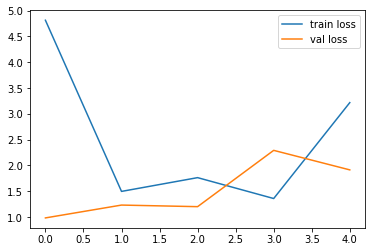

<Figure size 432x288 with 0 Axes>

In [ ]:
# loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

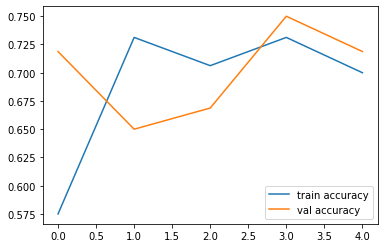

<Figure size 432x288 with 0 Axes>

In [ ]:
# accuracies
plt.plot(r.history['accuracy'], label='train accuracy')
plt.plot(r.history['val_accuracy'], label='val accuracy')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

import tensorflow as tf

from keras.models import load_model

model.save('facefeatures_new_model.h5')